# Computational Techniques for Differential Equations  
**Master in Applied and Computational Mathematics**  
**Academic Year 2025/2026**  

*Javier Miró Rodriguez*

*Enrique Zafra Mena*

---

## **Lab 2**

Implement a Python function to solve the following **Poisson problem** on a square domain using the **9-point finite difference Laplacian**, with boundary discretization **consistent with the same order of accuracy**:

$$
\nabla^2 u = -5\pi^2 \sin(\pi x)\cos(2\pi y), \qquad (x, y) \in [0, 1]^2,
$$

with boundary conditions

$$
u(x,0) = \sin(\pi x), \qquad
u(x,1) = \sin(\pi x),
$$
$$
\left.\frac{\partial u}{\partial x}\right|_{x=0} = \pi \cos(2\pi y), \qquad
\left.\frac{\partial u}{\partial x}\right|_{x=1} = -\pi \cos(2\pi y).
$$

The **exact solution** is
$$
u(x,y) = \sin(\pi x)\cos(2\pi y).
$$


---

## Exercises 

### **(a) Implement the solver**

Write a Python function:

```python
def poisson(a, b, m, u_exact, f_rhs, Lf_rhs, g):
    """
    Solve the 2D Poisson problem on a rectangular grid using the 9-point finite difference scheme.

    Parameters
    ----------
    a, b : float
        Domain boundaries in the x-direction.
    m : int
        Number of interior points in one dimension.
    u_exact : function
        Exact solution u(x,y), used for Dirichlet boundary conditions.
    f_rhs : function
        Right-hand side function f(x,y).
    Lf_rhs : function
        Correction term for the 9-point scheme.
    g : function
        Neumann boundary function.

    Returns
    -------
    X, Y : 2D ndarrays
        Grid coordinates including boundaries.
    U : 2D ndarray
        Numerical solution at all grid points.
    """
    # Step 1: Discretize the domain.
    # Step 2: Build the sparse matrix A using: 
    #         - the 9-point Laplacian (fourth-order accurate),
    #         - boundary conditions consistent with the scheme’s order,
    #         - and assemble the right-hand side vector using f(x, y).
    # Step 3: Solve the linear system A U = F.
    # Step 4: Reshape the full 2D solution including boundaries.

    return X, Y, U
```



In [ ]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve


def poisson(a, b, m, u_exact, f_rhs, Lf_rhs, g):
    """
    Solve the 2D Poisson problem on [a,b]x[a,b] with the 9-point (4th-order) FD scheme.
    BCs: Dirichlet on y=a and y=b via u_exact; Neumann on x=a and x=b via g.
    
    Parameters
    ----------
    a, b : float
        Square domain [a,b] x [a,b].
    m : int
        Number of interior points per dimension (requires m >= 4).
    u_exact : callable
        u_exact(x, y). Used for Dirichlet boundaries y=a and y=b.
    f_rhs : callable
        f(x,y) in Δu = f.
    Lf_rhs : callable
        Laplacian(f)(x,y) for the 9-point RHS correction: f + (h^2/12) * Lap(f).
    g : tuple or callable
        Neumann data for x=a and x=b. If tuple, g=(g_left, g_right) with g_left(y), g_right(y).
        If single callable, it must return a pair (g_left(y), g_right(y)).

    Returns
    -------
    X, Y : 2D ndarrays
        Grid coordinates including boundaries.
    U : 2D ndarray
        Numerical solution on all grid points (boundaries included).
    """

    # Step 1: Discretize the domain.
    h = (b - a) / (m + 1)
    x = np.linspace(a, b, m + 2)                
    y = np.linspace(a, b, m + 2)                 
    X, Y = np.meshgrid(x, y, indexing="xy")

    # Step 2: Build the sparse matrix A using:
    bottom = u_exact(x, np.full_like(x, a))      
    top    = u_exact(x, np.full_like(x, b))      

    gL_fun, gR_fun = g
    g_left  = lambda yy: gL_fun(yy)
    g_right = lambda yy: gR_fun(yy)


    nx = m + 2
    ny_int = m
    n_unknowns = nx * ny_int

    def k_index(i, j):
        return (j - 1) * nx + i

    s = 1.0 / (6.0 * h * h)
    c_center = -20.0 * s
    c_cross  =  4.0 * s
    c_diag   =  1.0 * s

    A = lil_matrix((n_unknowns, n_unknowns), dtype=float)
    F = np.zeros(n_unknowns, dtype=float)

    ## interiors for i=1..m, j=1..m
    for j in range(1, m + 1):
        yj = y[j]
        for i in range(1, m + 1):
            xi = x[i]
            k = k_index(i, j)

            # 9-point stencil at (i,j)
            A[k, k] = c_center

            # cross neighbors
            A[k, k_index(i - 1, j)] = c_cross
            A[k, k_index(i + 1, j)] = c_cross

            # (i,j-1) bottom Dirichlet si j-1 == 0
            if j - 1 >= 1:
                A[k, k_index(i, j - 1)] = c_cross
            else:
                F[k] -= c_cross * bottom[i]

            # (i,j+1) top Dirichlet if j+1 == m+1
            if j + 1 <= m:
                A[k, k_index(i, j + 1)] = c_cross
            else:
                F[k] -= c_cross * top[i]

            # diags (i-1,j-1)
            if j - 1 >= 1:
                A[k, k_index(i - 1, j - 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i - 1], a)  

            # (i+1,j-1)
            if j - 1 >= 1:
                A[k, k_index(i + 1, j - 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i + 1], a)

            # (i-1,j+1)
            if j + 1 <= m:
                A[k, k_index(i - 1, j + 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i - 1], b)  

            # (i+1,j+1)
            if j + 1 <= m:
                A[k, k_index(i + 1, j + 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i + 1], b)

            # RHS 
            F[k] += f_rhs(xi, yj) + (h * h / 12.0) * Lf_rhs(xi, yj)

    # neumann 4ht order
    inv12h = 1.0 / (12.0 * h)
    for j in range(1, m + 1):
        # left boundary row
        kL = k_index(0, j)
        A[kL, k_index(0, j)] += -25.0 * inv12h
        A[kL, k_index(1, j)] +=  48.0 * inv12h
        A[kL, k_index(2, j)] += -36.0 * inv12h
        A[kL, k_index(3, j)] +=  16.0 * inv12h
        A[kL, k_index(4, j)] +=  -3.0 * inv12h
        F[kL] += g_left(y[j])

        # right boundary row
        kR = k_index(m + 1, j)
        A[kR, k_index(m + 1, j)] +=  25.0 * inv12h
        A[kR, k_index(m,     j)] += -48.0 * inv12h
        A[kR, k_index(m - 1, j)] +=  36.0 * inv12h
        A[kR, k_index(m - 2, j)] += -16.0 * inv12h
        A[kR, k_index(m - 3, j)] +=   3.0 * inv12h
        F[kR] += g_right(y[j])

    # Step 3: Solve the linear system A U = F.
    U_strip = spsolve(A.tocsr(), F).reshape((m, m + 2))  # j=1..m, i=0..m+1

    # Step 4: Reshape the full 2D solution including boundaries.
    U = np.zeros((m + 2, m + 2), dtype=float)
    U[0, :] = bottom
    U[-1, :] = top
    U[1:-1, :] = U_strip

    return X, Y, U

---

### **(b) Verify numerical convergence**

1. Compute the numerical solution for progressively refined grids, e.g.,
   `m = 8, 16, 32, 64, 128`.

2. Compare the computed solution with the exact one and compute the **discrete** errors in the $\ell_\infty$-norm.

3. Plot the errors versus the grid spacing $h$ in a **log–log plot**, and verify that the scheme exhibits **fourth-order convergence** on a table.



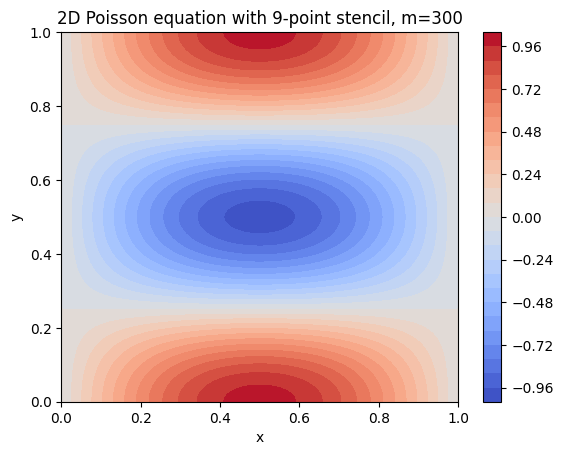

In [2]:
m = 300    
u_exact = lambda x,y: np.sin(pi*x)*np.cos(2*pi*y)
f_rhs   = lambda x,y: -5*pi**2*np.sin(pi*x)*np.cos(2*pi*y)
Lf_rhs  = lambda x,y: 25*pi**4*np.sin(pi*x)*np.cos(2*pi*y)   

g_left  = lambda y:  +pi*np.cos(2*pi*y)
g_right = lambda y:  -pi*np.cos(2*pi*y)

X, Y, U = poisson(a=0, b=1,
                  m=m, u_exact=u_exact,
                  f_rhs=f_rhs, Lf_rhs=Lf_rhs,
                  g =(g_left, g_right))


plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title(f'2D Poisson equation with 9-point stencil, m={m}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


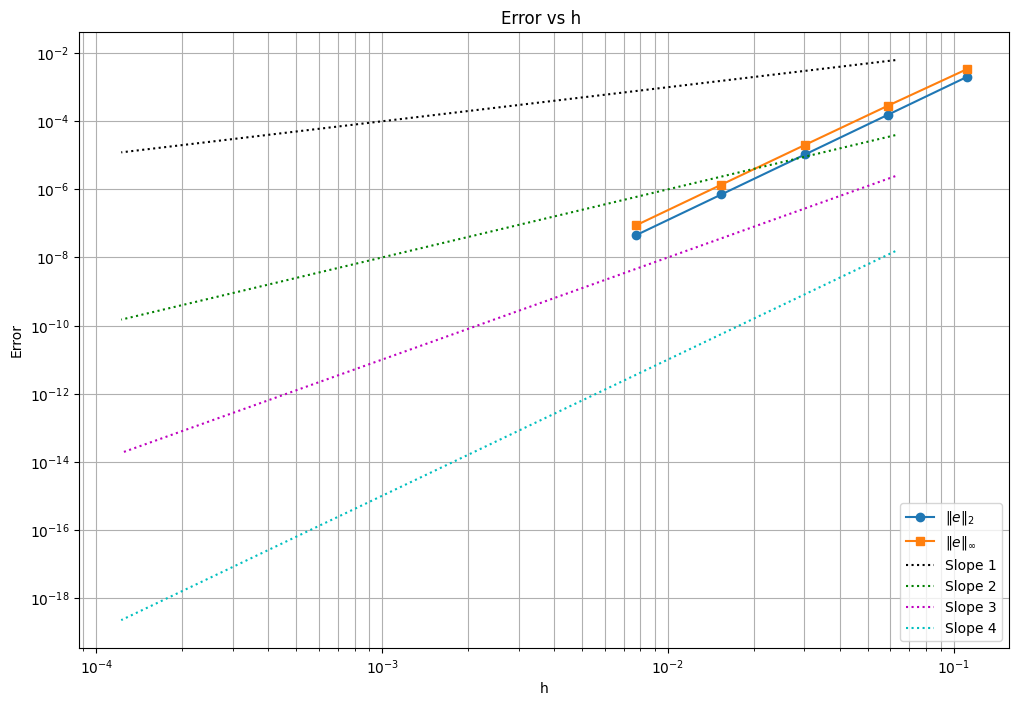

In [22]:
m_list = [8, 16, 32, 64, 128]

errors2 = []
errorsinf = []
hs = []

for m in m_list:
    X, Y, U_it = poisson(a=0.0, b=1.0, m=m,
                         u_exact=u_exact, f_rhs=f_rhs,
                         Lf_rhs=Lf_rhs, g=(g_left, g_right))
    h = 1.0 / (m + 1)  
    Uex = np.sin(np.pi*X) * np.cos(2*np.pi*Y)  

    E = U_it - Uex
    errorinf = np.max(np.abs(E))
    error2   = np.linalg.norm(E.ravel(), 2) * h

    errors2.append(error2)
    errorsinf.append(errorinf)
    hs.append(h)


hvec = 1.0 / 2**np.arange(4, 14)

plt.figure(figsize=(12, 8))
plt.loglog(hs, errors2,  'o-', label=r"$\|e\|_{2}$")
plt.loglog(hs, errorsinf,'s-', label=r"$\|e\|_{\infty}$")
plt.loglog(hvec, 0.1*hvec**1, 'k:', label="Slope 1")
plt.loglog(hvec, 0.01*hvec**2, 'g:', label="Slope 2")
plt.loglog(hvec, 0.01*hvec**3, 'm:', label="Slope 3")
plt.loglog(hvec, 0.001*hvec**4, 'c:', label="Slope 4")

ymin = min(min(errors2), min(errorsinf))
ymax = max(max(errors2), max(errorsinf))
#plt.xlim(min(hs), max(hs))
#plt.ylim(ymin*0.8, ymax*1.2)
plt.xlabel('h'); plt.ylabel('Error')
plt.title('Error vs h ')
plt.legend(); plt.grid(True, which='both')
plt.show()

---

### **(c) Bonus exercise (only for the brave and fearless!)** 

Modify your script to solve the problem on a rectangular domain $[0,1]\times[0,1/2]$. Note that the interior scheme is still the 4th-order 9-point Laplacian, which requires square grid spacing $h_x = h_y=h$. You must choose $m$ and $n$ such that this condition is satisfied.



In [11]:
n = (301+1)*(0.5/1) -1
n

150.0

Here the points on y, n, has to follow the relation

$$
n(m) = (m+1)\frac{d-c}{b-a} -1 = \frac12 (m -1)
$$

In [18]:
def poisson_rect(ax, bx, ay, by, m_x, m_y, u_exact, f_rhs, Lf_rhs, g):
    h_x = (bx-ax)/(m_x+1)
    h = h_x

    # --- mallas
    x = np.linspace(ax, bx, m_x + 2)            
    y = np.linspace(ay, by, m_y + 2)           
    X, Y = np.meshgrid(x, y, indexing="xy")

    # Dirichlet en y
    bottom = u_exact(x, np.full_like(x, ay))    
    top    = u_exact(x, np.full_like(x, by))    

    # Neumann en x
    gL_fun, gR_fun = g
    g_left  = lambda yy: gL_fun(yy)
    g_right = lambda yy: gR_fun(yy)

    nx = m_x + 2            
    ny_int = m_y            
    n_unknowns = nx * ny_int

    def k_index(i, j):
        return (j - 1) * nx + i

    # 9pts coefficients
    s = 1.0 / (6.0 * h * h)
    c_center = -20.0 * s
    c_cross  =  4.0 * s
    c_diag   =  1.0 * s

    A = lil_matrix((n_unknowns, n_unknowns), dtype=float)
    F = np.zeros(n_unknowns, dtype=float)

    # interior points
    for j in range(1, m_y + 1):
        yj = y[j]
        for i in range(1, m_x + 1):
            xi = x[i]
            k = k_index(i, j)

            A[k, k] = c_center

            A[k, k_index(i - 1, j)] = c_cross
            A[k, k_index(i + 1, j)] = c_cross

            if j - 1 >= 1:
                A[k, k_index(i, j - 1)] = c_cross
            else:
                F[k] -= c_cross * bottom[i]

            if j + 1 <= m_y:
                A[k, k_index(i, j + 1)] = c_cross
            else:
                F[k] -= c_cross * top[i]

            # diags
            # (i-1, j-1)
            if j - 1 >= 1:
                A[k, k_index(i - 1, j - 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i - 1], ay)

            # (i+1, j-1)
            if j - 1 >= 1:
                A[k, k_index(i + 1, j - 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i + 1], ay)

            # (i-1, j+1)
            if j + 1 <= m_y:
                A[k, k_index(i - 1, j + 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i - 1], by)

            # (i+1, j+1)
            if j + 1 <= m_y:
                A[k, k_index(i + 1, j + 1)] = c_diag
            else:
                F[k] -= c_diag * u_exact(x[i + 1], by)

            # RHS corrected
            F[k] += f_rhs(xi, yj) + (h * h / 12.0) * Lf_rhs(xi, yj)

    # rows
    inv12h = 1.0 / (12.0 * h)
    for j in range(1, m_y + 1):
        # left (i=0)
        kL = k_index(0, j)
        A[kL, k_index(0, j)] += -25.0 * inv12h
        A[kL, k_index(1, j)] +=  48.0 * inv12h
        A[kL, k_index(2, j)] += -36.0 * inv12h
        A[kL, k_index(3, j)] +=  16.0 * inv12h
        A[kL, k_index(4, j)] +=  -3.0 * inv12h
        F[kL] += g_left(y[j])

        # right (i=m_x+1)
        kR = k_index(m_x + 1, j)
        A[kR, k_index(m_x + 1, j)] +=  25.0 * inv12h
        A[kR, k_index(m_x,     j)] += -48.0 * inv12h
        A[kR, k_index(m_x - 1, j)] +=  36.0 * inv12h
        A[kR, k_index(m_x - 2, j)] += -16.0 * inv12h
        A[kR, k_index(m_x - 3, j)] +=   3.0 * inv12h
        F[kR] += g_right(y[j])

    # Step 3: Solve the system
    U_strip = spsolve(A.tocsr(), F).reshape((m_y, m_x + 2))  # j=1..m_y, i=0..m_x+1

    # Step 4;
    U = np.zeros((m_y + 2, m_x + 2), dtype=float)
    U[0, :] = bottom
    U[-1, :] = top
    U[1:-1, :] = U_strip

    return X, Y, U

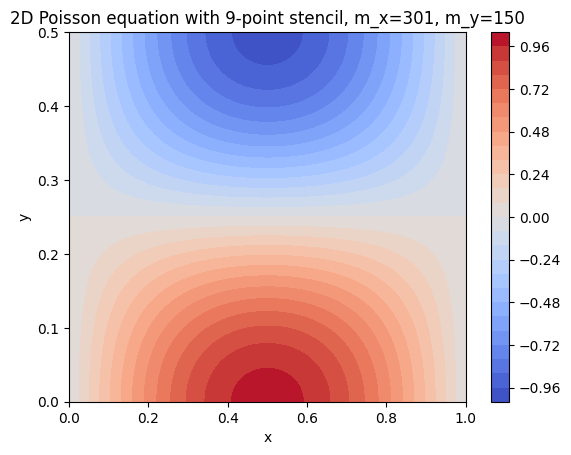

In [19]:
mx = 301
my = 150    
u_exact = lambda x,y: np.sin(pi*x)*np.cos(2*pi*y)
f_rhs   = lambda x,y: -5*pi**2*np.sin(pi*x)*np.cos(2*pi*y)
Lf_rhs  = lambda x,y: 25*pi**4*np.sin(pi*x)*np.cos(2*pi*y)   

g_left  = lambda y:  +pi*np.cos(2*pi*y)
g_right = lambda y:  -pi*np.cos(2*pi*y)

X, Y, U = poisson_rect(ax=0, bx=1, ay=0, by=0.5,
                  m_x=mx, m_y=my, u_exact=u_exact,
                  f_rhs=f_rhs, Lf_rhs=Lf_rhs,
                  g =(g_left, g_right))


plt.contourf(X, Y, U, 30, cmap='coolwarm')
plt.colorbar()
plt.title(f'2D Poisson equation with 9-point stencil, m_x={mx}, m_y={my}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


---